# Guided Project: Answering Business Questions Using SQL

## Import Libraries

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

## Helper Functions

In [2]:
# Create a run_query() function, that takes a SQL query as an argument and returns a pandas dataframe of that query.
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
# Create a run_command() function that takes a SQL command as an argument and executes it using the sqlite module.
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
# Create a show_tables() function that calls the run_query() function to return a list of all tables and views in the database.
def show_tables():
    q = """
    SELECT 
        name, 
        type 
    FROM sqlite_master 
    WHERE type IN ("table", "view")
    """ 
    return run_query(q)

show_tables()        

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Query identifying the best sellin genres in the USA

In [3]:
albums_to_purchase = '''
WITH tracks_sold_usa AS
    (
    SELECT
    il.* FROM invoice_line il           
    INNER JOIN invoice i on i.invoice_id = il.invoice_id
    INNER JOIN customer c on c.customer_id = i.customer_id
    WHERE c.country = "USA"
    )
    
SELECT
g.name genre,
COUNT(tsu.invoice_line_id) tracks_sold,
cast(COUNT(tsu.invoice_line_id) as float) / (SELECT count(*) FROM tracks_sold_usa) percentage_sold
FROM tracks_sold_usa tsu
INNER JOIN track t on t.track_id = tsu.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 desc
LIMIT 10;
'''

run_query(albums_to_purchase)
            
            

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


## Visualisation of the best selling genres in the USA

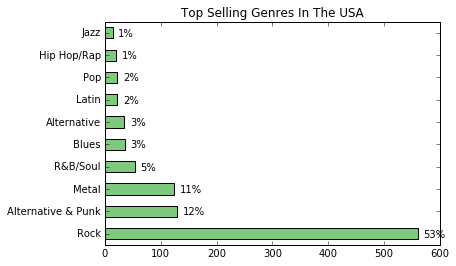

In [4]:
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa["tracks_sold"].plot.barh(
    title = "Top Selling Genres In The USA",
    xlim = (0,600),
    colormap = plt.cm.Accent
    )

plt.ylabel('')

#Taken from solution
for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

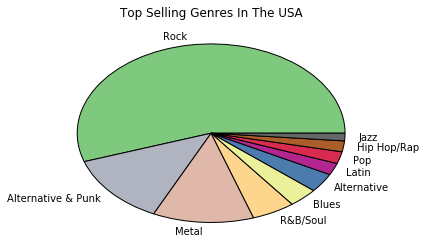

In [5]:
#Pie Chart Practice
genre_sales_usa["tracks_sold"].plot.pie(
    title = "Top Selling Genres In The USA",
    fig = (8,8),
    colormap = plt.cm.Accent
    )

plt.ylabel('')    
plt.show()    




### Findings 

The data clearly identifies "Rock" as the best selling genre in the USA. Based on the 4 album options being namely, hip-hop, punk, pop and blues the following three artists' albums should be purchased:

1. Red Tone - Punk
2. Slim Jim Bites - Blues
3. Meteor and the Girls - Pop

Regal - Hip-hop is not recommended based on the best selling tracks by genre data. 



In [6]:
q = '''SELECT
    c.customer_id customer,
    c.support_rep_id rep,
    sum(i.total) total
    FROM customer c
    INNER JOIN invoice i on i.customer_id = c.customer_id
    GROUP BY 1,2
    LIMIT 5;'''
run_query(q)

,customer,rep,total
0,1,3,108.90
1,3,3,99.99
2,12,3,82.17
3,15,3,66.33
4,18,3,79.20


## Sales Performance Analysis

In [7]:
total_employee_sales = '''
WITH customer_sales AS
    (
    SELECT
    c.customer_id customer,
    c.support_rep_id rep,
    sum(i.total) total
    FROM customer c
    INNER JOIN invoice i on i.customer_id = c.customer_id
    GROUP BY 1,2
    )
    
SELECT
    e.first_name || " " || e.last_name name,
    e.hire_date,
    SUM(cs.total) total_sales
FROM customer_sales cs
INNER JOIN employee e on e.employee_id = cs.rep
GROUP BY 1
ORDER BY 3 DESC;
'''

run_query(total_employee_sales)
    

    
    
    
    
    

,name,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


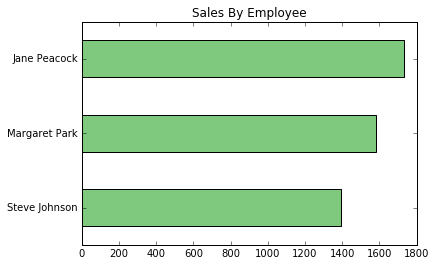

In [8]:
sales_performance = run_query(total_employee_sales)
sales_performance.set_index("name", inplace=True, drop=True)
sales_performance.sort_values("total_sales", inplace=True)

sales_performance["total_sales"].plot.barh(
    title = 'Sales By Employee',
    xlim = (0,1800),
    colormap = plt.cm.Accent
    )
plt.ylabel('')
plt.show()

### Findings

The data shows a 20% diffence in sales between the top and bottom employees. This is explained by their different hiring dates.

In [9]:
q = '''SELECT
         i.customer_id,
         c.country,
         sum(i.total) total_purchases,
         count(distinct i.invoice_id),
         count(distinct i.customer_id)
     FROM invoice i
     INNER JOIN customer c on c.customer_id = i.customer_id
     GROUP BY 2'''

run_query(q)

#Solution uses il to get the unit price. find out tomorrow why the unit price is required

,customer_id,country,total_purchases,count(distinct i.invoice_id),count(distinct i.customer_id)
0,56,Argentina,39.60,5,1
1,55,Australia,81.18,10,1
2,7,Austria,69.30,9,1
3,8,Belgium,60.39,7,1
4,13,Brazil,427.68,61,5
5,33,Canada,535.59,76,8
6,57,Chile,97.02,13,1
7,5,Czech Republic,273.24,30,2
8,9,Denmark,37.62,10,1
9,44,Finland,79.20,11,1


## Analysing Sales By Country

In [10]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


## Visualising Sales By Country

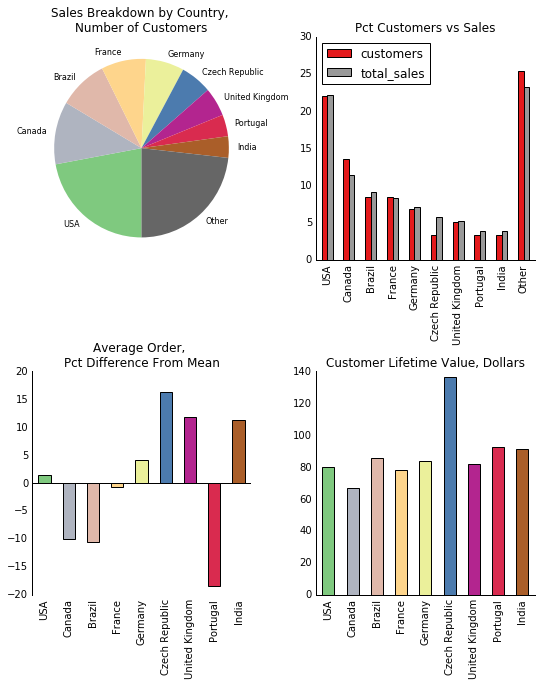

In [11]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", inplace=True, drop=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)

# top left
sales_breakdown = country_metrics['total_sales'].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title = 'Sales Breakdown by Country, \nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)    

# Top Right
cvd_cols = ["customers", "total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)    
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

#bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order, \nPct Difference From Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# Bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other", inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

### Findings

Copied:



Based on the data, there may be opportunity in the following countries:

- Czech Republic
- United Kingdom
- India

It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.


In [16]:
albums_vs_singles = '''
WITH invoice_first_track as
    (
    SELECT
        il.invoice_id invoice_id,
        MIN(il.track_id) first_track_id
    FROM invoice_line il
    GROUP BY 1
    )
    
SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (SELECT COUNT(*) FROM invoice
                                        ) percent
FROM
    (
     SELECT
         ifs.*,
         CASE
             WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                      )
                  
                  EXCEPT
                  
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                  ) IS NULL
              AND
                  (
                  SELECT il2.track_id FROM invoice_line il2
                  where il2.invoice_id = ifs.invoice_id
                  
                  EXCEPT
                  
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                      )
                  ) IS NULL
                  THEN "yes"
                  ELSE "no"
           END AS "album_purchase"
        FROM invoice_first_track ifs
        )
GROUP BY album_purchase;
'''
run_query(albums_vs_singles)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


### Findings

With album purchases making up 18.5% of total sales or almost 1/5 of total sales. It is not recommended that management changes the purchasing strategy to purchase only the most popular songs. 